In [1]:
import pandas as pd
import numpy as np
import matplotlib
import re

from matplotlib import pyplot as plt

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
df = pd.read_csv('sgRNA.final_list.sequence.bed', sep='\t', header=None)

In [4]:
df.head()

,0,1,2,3,4,5
0,chr1,11731445,11731464,GHSGRNALIB_1702:00001,TTCAGTTTGCCTTACTCGT,>chr1:11731415-11731815|chr1:11731445-11731464|-
1,chr1,11731460,11731479,GHSGRNALIB_1702:00002,TGAACCTACCAGGCTTGCG,>chr1:11731415-11731815|chr1:11731460-11731479|+
2,chr1,11731473,11731492,GHSGRNALIB_1702:00003,CTTGCGTGGAGGGGACAGA,>chr1:11731415-11731815|chr1:11731473-11731492|+
3,chr1,11731540,11731559,GHSGRNALIB_1702:00004,GTCCTCTCTGCGAAGCTCG,>chr1:11731415-11731815|chr1:11731540-11731559|+
4,chr1,11731541,11731560,GHSGRNALIB_1702:00005,TCCTCTCTGCGAAGCTCGA,>chr1:11731415-11731815|chr1:11731541-11731560|+


In [60]:
n, f = df.shape
enh_id = np.zeros(n)
sgrna_coods = np.zeros([n, 2])
all_regions = []

current_enh_id = 0
chr1, enh_pos, chr2, sgrna_pos, strand = re.split('[\| | :]', df[5][0])
current_enh = chr1 + ":"  + enh_pos
all_regions.append(current_enh[1:])

for i, e in enumerate(df[5]):
    chr1, enh_pos, chr2, sgrna_pos, strand = re.split('[\| | :]', e)
    
    input_enh = chr1 + ":"  + enh_pos
    
    if input_enh != current_enh:
        current_enh_id +=1
        current_enh = input_enh
        all_regions.append(current_enh[1:])

    enh_id[i] = int(current_enh_id)
    enh_left, enh_right = enh_pos.split('-')
    sgrna_left, sgrna_right = sgrna_pos.split('-')
    
    midpoint = (int(enh_left) + int(enh_right)) / 2
    sgrna_coods[i] = [int(i) - midpoint for i in sgrna_pos.split('-')]

In [92]:
#get the hits bool
hits_regions = pd.read_csv('hits_regions.hg19.bed', sep='\t', header=None)[0].values

hits_bool = []

for r in all_regions:
    if r in hits_regions:
        hits_bool.append(1)
    else:
        hits_bool.append(0)

In [4]:
plot_df = pd.DataFrame(sgrna_coods)
plot_df['enh_id'] = enh_id

In [5]:
min_vals = np.array([])
for i in np.unique(plot_df['enh_id']):
    current_df = plot_df[plot_df['enh_id'] == i].iloc[:, 0:2]
    nn,ii = current_df.shape
    current_min = np.min(np.min(current_df))
    
    min_vals = np.append(min_vals, np.array([current_min] * nn))

In [6]:
plot_df['min_vals'] = min_vals

In [66]:
plot_df_sorted = plot_df.sort_values(by=['min_vals', 'enh_id'])

In [75]:
sorted_enh_idx = []
current_i = plot_df_sorted.enh_id.values[0]
sorted_enh_idx.append(int(current_i))

for i in plot_df_sorted.enh_id.values:
    if i != current_i:
        current_i = i
        sorted_enh_idx.append(int(current_i))

In [8]:
x_coord = 0
current_id = plot_df_sorted['enh_id'][0]
new_id = np.array([])

for i in plot_df_sorted['enh_id']:
    if i != current_id:
        x_coord +=1
        current_id = i
    new_id = np.append(new_id, x_coord)

In [9]:
plot_df_sorted['new_id'] = new_id

In [10]:
mtx_min = np.min(np.min(plot_df_sorted.iloc[:,0:2]))
mtx_max = np.max(np.max(plot_df_sorted.iloc[:,0:2]))
y_dim = int(np.abs(mtx_min) + np.abs(mtx_max))
x_dim = int(np.max(plot_df_sorted['new_id']))

In [11]:
dis_mtx = np.zeros((x_dim, y_dim))

In [12]:
for i in np.arange(n):
    left_coo, right_coo = plot_df_sorted.iloc[i,0:2]
    x_coo = int(plot_df_sorted.iloc[i, 4]-1)
    
    dis_mtx[x_coo, int(left_coo-mtx_min):int(right_coo-mtx_min)] = 1

Text(0, 0.5, 'Enhancers')

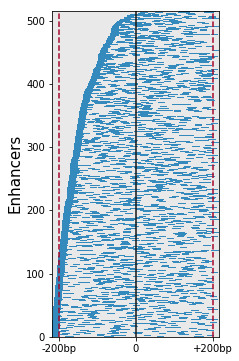

In [13]:
from matplotlib import colors
cmap = colors.ListedColormap(['#E9E9E9', '#348ABD'])

fig, ax= plt.subplots(figsize=(3,6))

ax.pcolor(dis_mtx, cmap=cmap)

ax.axvline(x=218,linestyle='-', color='#151515')
ax.axvline(x=18, linestyle = '--', color='#A60628')
ax.axvline(x=418, linestyle = '--', color='#A60628')

ax.set_xticks([18, 218, 418])
ax.set_xticklabels(['-200bp', '0', '+200bp'])
ax.set_ylabel('Enhancers', fontsize=15)
#plt.savefig('sgRNA_pos-summary.pdf')

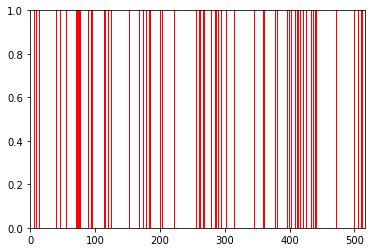

In [106]:
test = np.array(hits_bool)[sorted_enh_idx]
hits_cmap = matplotlib.colors.ListedColormap(['w', 'r'])

fig, ax = plt.subplots()
hits_id = ax.pcolormesh([test],cmap=hits_cmap)